In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp

In [2]:
try:
    plt.style.use('neuroblu')
except:
    print('neuroblu style not found. Using default style!')

In [3]:
config = {
    'nbase': 250,
    'neca': 500,
}

In [4]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend()
    ax.set_title(col)
    return 

In [5]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]

np.random.seed(0)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.5, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.5, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [7]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]

x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = 1.5*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.4, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.6, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

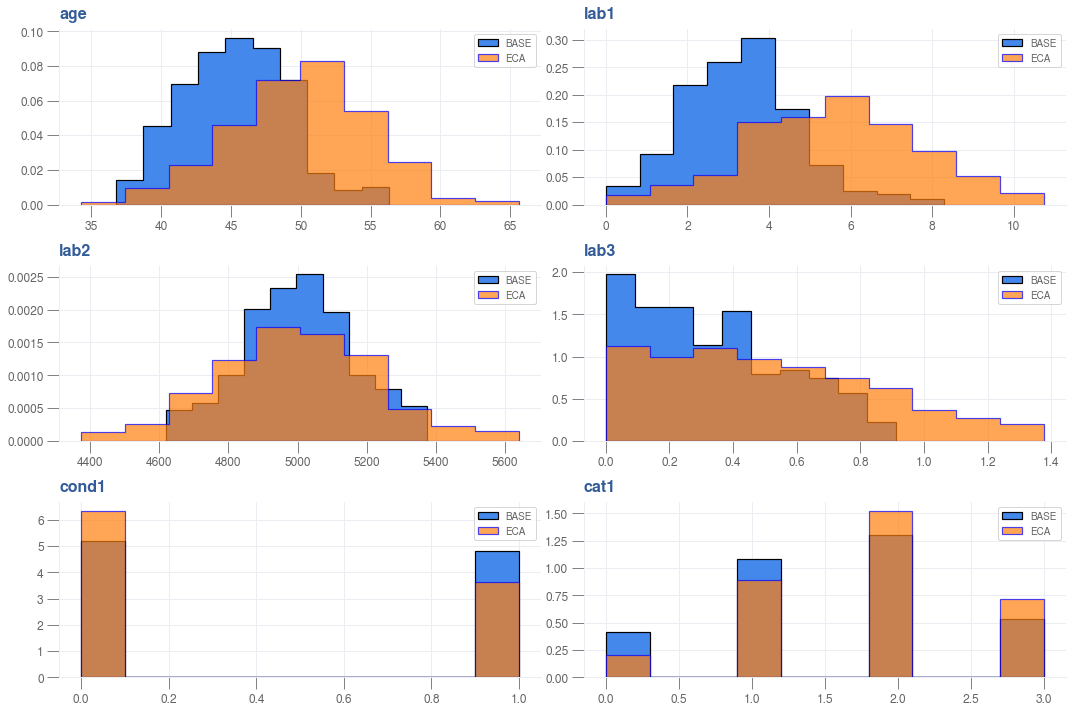

In [8]:
_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'BASE'
data_eca.name = 'ECA'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [ ]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])

In [ ]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, 50)

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, 50)

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, 50)

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, 50)

In [ ]:
kde_age = density_age(waypoints_age)
kde_lab1 = density_lab1(waypoints_lab1)
kde_lab2 = density_lab2(waypoints_lab2)
kde_lab3 = density_lab3(waypoints_lab3)

In [ ]:
def calc_loss(w):    
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    
    loss = (kde_age - est_den_age(waypoints_age))**2 + \
    (kde_lab1 - est_den_lab1(waypoints_lab1))**2 + \
    (kde_lab2 - est_den_lab2(waypoints_lab2))**2 + \
    (kde_lab3 - est_den_lab3(waypoints_lab3))**2
        
    return sum(loss)

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})

In [ ]:
%%time
weights = np.ones(config['neca'])/config['neca']

bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))
wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000}, bounds=bounds)
p = wopt.x

In [ ]:
wopt.success

In [ ]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=100)
data_eca_study.name = 'ECA'

In [ ]:
_, ax = plt.subplots(2,4, figsize=(15, 6))

plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[0][2])
plot_dist(data_base, data_eca, 'lab3', ax[0][3])

plot_dist(data_base, data_eca_study, 'age', ax[1][0])
plot_dist(data_base, data_eca_study, 'lab1', ax[1][1])
plot_dist(data_base, data_eca_study, 'lab2', ax[1][2])
plot_dist(data_base, data_eca_study, 'lab3', ax[1][3])

In [ ]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

In [27]:
v = np.random.binomial(1, 0.5, 5)
kernel = gaussian_kde(v)
Z = kernel([0, 1])

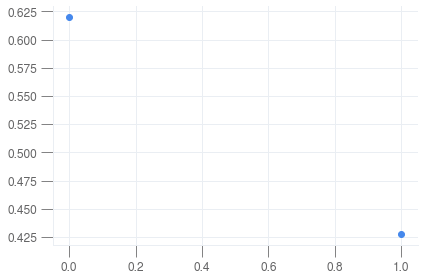

In [28]:
plt.scatter([0,1], Z)

In [33]:
from statsmodels.nonparametric.kde import KDEUnivariate

In [34]:
kde1= KDEUnivariate(np.array([10.,10.,10.,5.]))

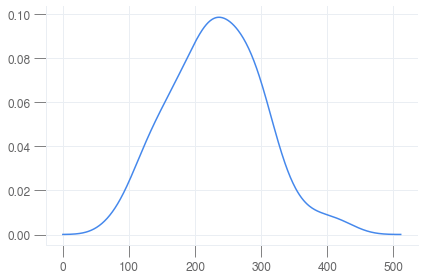

In [49]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(data_base['age'])
dens.fit()
plt.plot(dens.density)
plt.show()

In [52]:
(dens.evaluate([20, 25, 30, 35, 40]))

array([1.16986790e-38, 8.53527690e-21, 4.02870915e-09, 1.62935099e-03,
       4.73579198e-02])